# Email Marketing Campaigns Optimization Model with NLP


### Jupyter Notebook 7/10

#### Importing Classes from the module `campaigns`

In [1]:
import sys
sys.path.append('..')


import warnings
warnings.filterwarnings('ignore')

# Get files
from campaigns.getinputdata import LanguageFileGetInfo

# Feature Engineering
from campaigns.modeling.preprocessing import VerticalEncoder

from sklearn.feature_extraction.text import CountVectorizer

# Texts Preprocessing
from campaigns.modeling.nlp import (
    VerticalMessagePreprocessor,
    VerticalModelFeatureExtractor,
    VerticalModelGetWordVectors,
    VerticalModelGetPaddedSeqs,
    VerticalModelGetWeightMatrix,
)

# Texts Classification
from campaigns.modeling.classifiers import MultinomialNBClassifier

# Evaluation
from campaigns.modeling.evaluation import VerticalModelEvaluator

# Neural Networks
from campaigns.modeling.neuralnetworks import DeepLearningModelCreator

In [2]:
# Obtaining input

spanish = LanguageFileGetInfo(dataroot='../../../datasets/output/sample_01/output_06/', datafile='es.csv')

#### 4.2.5. Vectorization 

- Our first model is a supervised multi-class classification problem.

- We will create our input features from the texts contained in the column `message`.
- The output will be the predictions made on our target column `sector`.


Different approaches:

- We will create a baseline using two simpler vectorization approaches BoW and TF-IDF.
- We will try to improve the model using a dense representation of words by an embedding approach.

In [3]:
# Instantiate 

spanish = VerticalMessagePreprocessor(spanish.language_df, 'spanish')

In [4]:
# Checking the number of labeled messages

len(spanish.language_df)

9963

#### Normalization

- Tokenizing and removing empty strings
- Stemming
- Converting lists of tokens back to strings

In [5]:
# Preprocessing texts

spanish.preprocess_message(flag_stemming=True)

#### Encoding `sector`

In [6]:
# Creating an instance

spanish = VerticalEncoder(spanish.language_df)

In [7]:
spanish.sectors

array(['Entretenimiento, eventos y relaciones públicas',
       'Negocios, finanzas y banca', 'Órganos de gobierno',
       'Sin ánimo de lucro', 'Ecommerce',
       'Medios de comunicación, marketing y publicidad',
       'Ordenadores, electrónica y tecnología móvil',
       'Educación y empleo', 'Salud, bienestar y cuidado personal',
       'Legal y seguros',
       'Arquitectura, construcción y sector inmobiliario', 'Restauración',
       'Ocio, turismo y experiencias', 'Asociación cultural o religiosa'],
      dtype=object)

In [8]:
spanish.language_df[['sector']]

,sector
8,"Entretenimiento, eventos y relaciones públicas"
13,"Negocios, finanzas y banca"
18,Órganos de gobierno
19,"Entretenimiento, eventos y relaciones públicas"
23,Sin ánimo de lucro
...,...
99974,"Arquitectura, construcción y sector inmobiliario"
99981,Ecommerce
99992,"Medios de comunicación, marketing y publicidad"
99995,Sin ánimo de lucro


In [9]:
spanish.change_names()
spanish.language_df[['sector']]

,sector
8,entertainment
13,finance
18,government
19,entertainment
23,nonprofit
...,...
99974,architecture
99981,ecommerce
99992,media
99995,nonprofit


In [10]:
# Checking the number of classified campaigns per category

spanish.check_categories()

Number of categories: 14
media           17.71
ecommerce       16.14
nonprofit       14.88
education       13.90
wellness         6.32
finance          5.71
architecture     5.05
technology       4.61
government       4.52
leisure          4.36
entertainment    3.58
legal            1.66
catering         1.17
association      0.40
Name: sector, dtype: float64


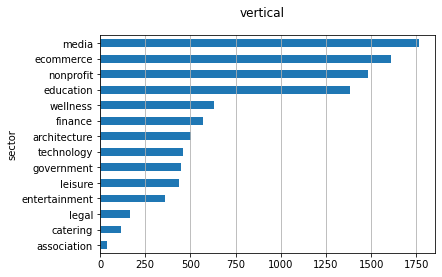

In [11]:
spanish.plot_categories()

In [12]:
# Deleting rows with less than 4 samples in 'sector'

spanish.small_samples_remover(4)

In [13]:
spanish.language_df['sector'].value_counts()

media            1764
ecommerce        1608
nonprofit        1482
education        1385
wellness          630
finance           569
architecture      503
technology        459
government        450
leisure           434
entertainment     357
legal             165
catering          117
association        40
Name: sector, dtype: int64

In [14]:
spanish.label_encoding()

In [15]:
sector_id_df = spanish.label_encoding_df()
sector_id_df

,sector,sector_cat_id
0,architecture,0
1,association,1
2,catering,2
3,ecommerce,3
4,education,4
5,entertainment,5
6,finance,6
7,government,7
8,legal,8
9,leisure,9


#### 4.2.6.1. BoW Approach

##### Transforming our word sequences into **numerical features**.


- The column `message` contains textual data from which we will extract our features.

- The column `sector` is the label that we are learning to predict. 

In [16]:
spanish = VerticalModelFeatureExtractor(CountVectorizer, spanish.language_df, sector_id_df)

##### Observing features and target 

In [17]:
print('Feature dimensions: ', spanish.features.ndim)
print('Number of messages: ', spanish.features.shape)

Feature dimensions:  1
Number of messages:  (9963,)


In [18]:
print('Target dimensions: ', spanish.target.ndim)
print('Number of messages: ', spanish.target.shape)

Target dimensions:  1
Number of messages:  (9963,)


#### Splitting the data to avoid data leakage

- The **classification model** should be fitted with the training data.
- **Predictions** should be obtained from test.

Vertical=5, n=357 (3.583%)
Vertical=6, n=569 (5.711%)
Vertical=7, n=450 (4.517%)
Vertical=11, n=1482 (14.875%)
Vertical=3, n=1608 (16.140%)
Vertical=10, n=1764 (17.706%)
Vertical=12, n=459 (4.607%)
Vertical=4, n=1385 (13.901%)
Vertical=13, n=630 (6.323%)
Vertical=8, n=165 (1.656%)
Vertical=0, n=503 (5.049%)
Vertical=2, n=117 (1.174%)
Vertical=9, n=434 (4.356%)
Vertical=1, n=40 (0.401%)


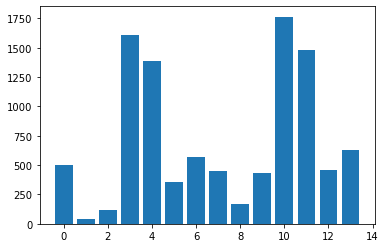

In [19]:
# Observing target disribution

spanish.target_plotter(spanish.target)

In [20]:
features_train, features_test, target_train, target_test = spanish.splitter()
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(8966,) (8966,)
(997,) (997,)


In [21]:
# Obtaining the vectorizer

vectorizer = spanish.get_vectorizer()
vectorizer

CountVectorizer()

In [22]:
# Training the vectorizer

vec_features_train, vectorizer = spanish.vectorizer_train(features_train)

In [23]:
vec_features_train.shape

(8966, 61767)

In [24]:
# SMOTE oversampling

%time vec_features_train, target_train = spanish.target_smotter(vec_features_train, target_train)

CPU times: user 54.7 s, sys: 45.7 s, total: 1min 40s
Wall time: 1min 36s


Vertical=3, n=1592 (7.143%)
Vertical=11, n=1592 (7.143%)
Vertical=4, n=1592 (7.143%)
Vertical=12, n=1592 (7.143%)
Vertical=10, n=1592 (7.143%)
Vertical=13, n=1592 (7.143%)
Vertical=0, n=1592 (7.143%)
Vertical=9, n=1592 (7.143%)
Vertical=7, n=1592 (7.143%)
Vertical=6, n=1592 (7.143%)
Vertical=5, n=1592 (7.143%)
Vertical=1, n=1592 (7.143%)
Vertical=8, n=1592 (7.143%)
Vertical=2, n=1592 (7.143%)


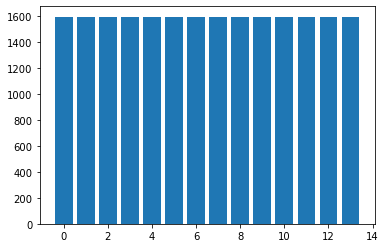

In [25]:
spanish.target_plotter(target_train)

####  Detecting Verticals: 

- Our aim is to use the predictions that we obtain from this first model as a feature for our second or Main Model.

- Vertical or First Model - Multi-class classification problem.

#### Machine Learning Model

Steps:

1. Transforming test data into the **same feature vector** as the training data*.


2. **Training** the classifier and predict for test data.


3. Evaluating the classifier.

*Every observation should have the same number of features in the same order

####  Transforming test data into the **same feature vector** as the training data

In [26]:
# Create an instance

model = MultinomialNBClassifier(features_test, vectorizer, vec_features_train, target_train)

In [27]:
vec_features_test =  model.vectorizer_test()

#### Observing the dimension of the resulting feature vector

In [28]:
print(vec_features_train.ndim) # m x n matrix
print(vec_features_test.ndim)

print(vec_features_train.shape)
print(vec_features_test.shape)

2
2
(22288, 61767)
(997, 61767)


In [29]:
print(f'The dimension of our feature vector is {vec_features_train.shape[1]}.')

The dimension of our feature vector is 61767.


Each vector represents the frequency of a word in the predefined dictionary of words:

In [30]:
print(vec_features_train)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
vec_features_test

<997x61767 sparse matrix of type '<class 'numpy.int64'>'
	with 106669 stored elements in Compressed Sparse Row format>

#### Observing our vocabulary

In [32]:
print(f'Size of the vocabulary: {vec_features_train.shape[1]} tokens.')

Size of the vocabulary: 61767 tokens.


In [33]:
# vocabulary of all the unique words in our messages

word_index = vectorizer.vocabulary_

In [34]:
# each word has its own index
# get index from word

word_index['entrad']

21013

In [35]:
#get word from index

reversed_word_index = dict((value, key) for (key, value) in vectorizer.vocabulary_.items())

In [36]:
reversed_word_index[0]

'aa'

In [37]:
reversed_word_index[61000]

'xiquet'

In [38]:
print({key:reversed_word_index[key] for key in set(range(3400,3420)) & set(reversed_word_index)})

{3400: 'antipar', 3401: 'antiparasitari', 3402: 'antiparticl', 3403: 'antipat', 3404: 'antipolill', 3405: 'antipolv', 3406: 'antipotencial', 3407: 'antiqu', 3408: 'antiquisim', 3409: 'antiresfri', 3410: 'antiretroviral', 3411: 'antirob', 3412: 'antirrac', 3413: 'antirreflect', 3414: 'antirreflej', 3415: 'antirretorn', 3416: 'antirreumaticosal', 3417: 'antirrob', 3418: 'antirrumor', 3419: 'antirus'}


#### **Training** the classifier and predicting for test data using a Multinomial Naive Classifier

In [39]:
# Creating an instance

classifier = model.get_multinomial_nb_classifier()

In [40]:
classifier

MultinomialNB()

In [41]:
# Training the model and timing it

%time model.classifier_training(classifier)

CPU times: user 11min 54s, sys: 2min 39s, total: 14min 34s
Wall time: 15min 24s


In [42]:
# Predicting Vertical

predictions = model.classifier_predict(classifier, vec_features_test)

In [43]:
len(predictions)

997

#### Evaluating the classifier

In [44]:
evaluation = VerticalModelEvaluator(target_test, predictions, features_test)

In [45]:
evaluation.get_classification_report()


Classification Report

               precision    recall  f1-score   support

           0       0.97      0.84      0.90        45
           1       1.00      1.00      1.00         2
           2       1.00      0.88      0.93        16
           3       0.96      0.92      0.94       167
           4       0.95      0.96      0.96       145
           5       0.91      0.93      0.92        44
           6       0.90      0.95      0.92        57
           7       0.98      0.96      0.97        45
           8       0.70      0.84      0.76        19
           9       0.93      0.95      0.94        39
          10       0.85      0.94      0.89       172
          11       0.98      0.82      0.89       141
          12       0.93      0.89      0.91        45
          13       0.77      0.93      0.84        60

    accuracy                           0.91       997
   macro avg       0.92      0.91      0.91       997
weighted avg       0.92      0.91      0.91       997



In [46]:
evaluation.get_confusion_matrix()


Confusion Matrix

 [[ 38   0   0   0   0   0   0   0   0   0   2   0   3   2]
 [  0   2   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  14   0   0   1   0   1   0   0   0   0   0   0]
 [  0   0   0 154   0   3   0   0   0   0   3   0   0   7]
 [  1   0   0   0 139   0   1   0   1   0   2   0   0   1]
 [  0   0   0   0   0  41   0   0   0   0   3   0   0   0]
 [  0   0   0   0   0   0  54   0   1   0   1   0   0   1]
 [  0   0   0   0   0   0   0  43   0   0   1   1   0   0]
 [  0   0   0   1   0   0   0   0  16   0   1   0   0   1]
 [  0   0   0   0   0   0   0   0   0  37   0   0   0   2]
 [  0   0   0   2   1   0   1   0   1   2 162   1   0   2]
 [  0   0   0   1   4   0   4   0   4   0  12 115   0   1]
 [  0   0   0   1   2   0   0   0   0   0   2   0  40   0]
 [  0   0   0   1   0   0   0   0   0   1   2   0   0  56]]


#### Checking which messages have been misclassified

In [47]:
sector_id_df

,sector,sector_cat_id
0,architecture,0
1,association,1
2,catering,2
3,ecommerce,3
4,education,4
5,entertainment,5
6,finance,6
7,government,7
8,legal,8
9,leisure,9


In [48]:
results_df = evaluation.get_results_df()

#results_df[(results_df['actual_label']==0) & (results_df['predicted_class']!=0)]

In [49]:
evaluation.get_misclassified(results_df)

8.625877632898696

In [50]:
# evaluation.save_classification_report("../../../datasets/reports", "sample_01_vertical_bow")

#### 4.2.6.2. TF-IDF Approach

- Trying to improve the current model changing the vectorization step.
- Using TF instead of word counts and dividing the number of occurrences by the sequence length.
- Downscaling these frequencies (IDF) so that words with greater occurrences get lower values.
- Downside of this approach: features resulting from TFIDF are **not able to capture semantics**.

In [51]:
cd ../03_Scripts/

[Errno 2] No such file or directory: '../03_Scripts/'
/Users/danielaperezduro/Desktop/Proyectos/GitHub/campaignclassificationwnlp/notebooks/01_Main_Model


In [52]:
! python 05_verticalmodel_model_selection.py --input_root ../../../datasets/output/sample_01/output_06/ --input_file es.csv --vectorizer TfidfVectorizer --stemmer spanish

python: can't open file '05_verticalmodel_model_selection.py': [Errno 2] No such file or directory


- Our first model ('Vertical Model') improves slighltly using a TF-IDF Vectorizer.

#### 4.2.6.3. Creating a Word Embedding model usign Word2Vec

- Trying to improve the model using dense representations of words instead of the sparse representations provided by BoW and Tfidf.

- These dense representations will be learned from the train part of our messages (our corpus). 

- They will be used later in the first layer of a neural network as weights.

**Steps**:

- 4.2.6.3.1. Defining the training data.

- 4.2.6.3.2. Training a Word2Vec model from scratch with gensim to obtain word vectors.

- 4.2.6.3.3. Building a deep learning model using these Word2Vec vectors.

#### 4.2.6.3.1. Defining the training data

- Converting the texts in `message` into lists of normalized tokens (without stopwords).
- Converting the target into categorical.
- Splitting between train and test: we will use the train part to learn our word embeddings.

In [53]:
# Creating an instance

spanish = VerticalModelGetWordVectors(spanish.language_df, 'spanish')

Reshaping the target with one-hot encoding
Converting our texts into lists of tokens
Removing empty tokens
Removing stopwords


#### Checking number of messages (rows) before splitting

In [54]:
len(spanish.sentences)

9963

#### Splitting between train and test

In [55]:
spanish.target

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [56]:
features_train, features_test, target_train, target_test = spanish.splitter()

In [57]:
len(features_train)

8966

In [58]:
len(features_test)

997

#### 4.2.6.3.2. Training a Word2Vec model from scratch with gensim using `features_train` 

Word2Vec Hyperparameters:

- **Training algorithm**: we will use the default training algorithm **CBOW**.

- **Size**: our model will learn a 100-dimensional vector representation fo each word.

- **Minimum count of words**: words with a frequency of less than 3 will not be taken into account.

- **Window**: the maximum distance between a target word and its words around; we will use the default value 5..

In [59]:
corpus, model = spanish.getting_embedding_model(features_train)

Corpus shape:  (8966,)


In [60]:
# observing word vector dimensions and vocabulary size

print(model)
print('Vector size: ', model.vector_size)

Word2Vec(vocab=61530, size=100, alpha=0.025)
Vector size:  100


- After training we have our embedding model with a vocabulary of  unique words.

- We can access to these word vectors through `model.wv`.

#### Checking token (word) representations through `model.wv`

- `KeyedVectors` structure: a mapping between `keys` and `vectors`.

- Each vector is identified by its lookup key (a word).

In [61]:
model_wv = model.wv
model_wv

- Each token (word) is represented as a 100-dimensional word vector:

In [88]:
model_wv['pued'][:]

array([ 0.23520581,  0.25290564, -0.5980762 , -1.6155307 ,  0.97513145,
        1.7241169 ,  0.51231796, -0.3641162 , -0.30367285, -3.034459  ,
        1.0809658 , -1.9971554 ,  1.2408084 ,  0.6893222 , -2.9726043 ,
        0.7047724 , -0.9034902 , -0.21054584, -2.3121076 , -0.6736801 ,
        0.74145246, -0.3821769 , -0.13568506,  0.6089339 , -1.6478314 ,
       -2.295446  ,  1.2722025 , -1.2004308 ,  0.93579596, -3.7272327 ,
       -1.6152098 ,  1.7984893 , -2.1130953 ,  1.6931496 , -0.01948503,
        1.9270988 , -1.8563615 ,  0.7343296 ,  2.1222718 ,  1.497756  ,
        0.5630167 , -1.2553537 ,  0.37000826, -0.09695441,  2.8435931 ,
        0.8141329 ,  0.6378183 ,  2.0879583 , -1.3905103 ,  0.5465934 ,
       -3.506855  , -1.039198  , -0.3066803 ,  2.1750906 ,  0.31656533,
       -1.6472175 ,  1.7418661 ,  1.6072242 ,  1.1103297 ,  1.7842867 ,
        2.8469305 , -0.76551807, -0.42637432, -1.7580034 , -2.600947  ,
        0.6341076 ,  0.90228814,  0.7161963 ,  1.6202338 , -1.80

#### Checking most similar words

In [72]:
model_wv.most_similar('presencial')

[('clas', 0.8311218023300171),
 ('modal', 0.8177667856216431),
 ('seminari', 0.8143434524536133),
 ('aul', 0.7972973585128784),
 ('laboralesplaz', 0.786739706993103),
 ('natacion', 0.7853668928146362),
 ('alumn', 0.7708033323287964),
 ('gratuit', 0.7644963264465332),
 ('sanitarial', 0.7594812512397766),
 ('diplom', 0.7525701522827148)]

In [74]:
model_wv.most_similar('niñ')

[('adult', 0.8610222339630127),
 ('adolescent', 0.7979990243911743),
 ('hipotec', 0.7423117160797119),
 ('muj', 0.7374426126480103),
 ('plen', 0.7338228225708008),
 ('hombr', 0.7284272313117981),
 ('cuatr', 0.7224066853523254),
 ('edad', 0.7146936655044556),
 ('nac', 0.7145366668701172),
 ('parej', 0.7113684415817261)]

In [75]:
model_wv.most_similar('profesor')

[('secundari', 0.9051446914672852),
 ('universitari', 0.8653284311294556),
 ('maestr', 0.8477373123168945),
 ('fp', 0.8404687643051147),
 ('docenci', 0.8365150094032288),
 ('arquitect', 0.8184137344360352),
 ('celador', 0.8071708679199219),
 ('docent', 0.8043333292007446),
 ('almeriamadr', 0.7892889976501465),
 ('enseñ', 0.7890660762786865)]

In [76]:
model_wv.most_similar('alemani')

[('franci', 0.9360690116882324),
 ('itali', 0.8542121052742004),
 ('milit', 0.8346668481826782),
 ('alemaniapost', 0.8165828585624695),
 ('terminadopost', 0.8126831650733948),
 ('multinacional', 0.8081051707267761),
 ('portugal', 0.806353747844696),
 ('fronter', 0.799864649772644),
 ('supus', 0.7996582984924316),
 ('satelit', 0.7961890697479248)]

In [78]:
model_wv.most_similar('coronavirus')

[('canc', 0.8706092238426208),
 ('farmac', 0.8548662662506104),
 ('grip', 0.852351725101471),
 ('brot', 0.8467246890068054),
 ('sarscov', 0.8422161936759949),
 ('contagi', 0.8114998936653137),
 ('pandemi', 0.8038771152496338),
 ('epidemi', 0.7908207774162292),
 ('cov', 0.789469838142395),
 ('poblacion', 0.7890412211418152)]

In [79]:
model_wv.most_similar('porcin')

[('colombial', 0.9257878661155701),
 ('pest', 0.9196913838386536),
 ('respiratori', 0.9007499814033508),
 ('prevalent', 0.8952677845954895),
 ('circovirus', 0.8884010910987854),
 ('reproduct', 0.8853830099105835),
 ('african', 0.8823903799057007),
 ('granj', 0.8632199764251709),
 ('enfermedad', 0.8626083135604858),
 ('ambiental', 0.8624659776687622)]

In [80]:
model_wv.most_similar('ilusion')

[('alegr', 0.8995333909988403),
 ('corazon', 0.899021565914154),
 ('sueñ', 0.8873536586761475),
 ('voy', 0.8857077360153198),
 ('magi', 0.8849211931228638),
 ('felic', 0.8779655694961548),
 ('volv', 0.8779242634773254),
 ('amor', 0.8654426336288452),
 ('cariñ', 0.8632555603981018),
 ('veng', 0.8521076440811157)]

In [81]:
model_wv.most_similar('occidental')

[('oligarqu', 0.8631521463394165),
 ('occident', 0.8439397215843201),
 ('gobi', 0.8404943943023682),
 ('geopolit', 0.8352060317993164),
 ('alin', 0.8290115594863892),
 ('belic', 0.8278498649597168),
 ('sistemat', 0.8188304901123047),
 ('crecient', 0.8185170888900757),
 ('destruccion', 0.8174668550491333),
 ('estall', 0.8117529153823853)]

In [83]:
model_wv.most_similar('lun')

[('viern', 0.9448037147521973),
 ('juev', 0.902559757232666),
 ('mañan', 0.8830177783966064),
 ('doming', 0.8632924556732178),
 ('miercol', 0.8271694183349609),
 ('mart', 0.8263916373252869),
 ('horari', 0.8259829878807068),
 ('directomuch', 0.8004377484321594),
 ('ener', 0.7968357801437378),
 ('noviembreconferent', 0.793911337852478)]

#### 4.2.6.3.3. Building a deep learning model with Word2Vec vectors

Steps

- Transforming texts into padded sequences of word ids.
- Creating an embedding matrix.
- Building a neural network with an embedding layer.

#### Transforming texts into padded sequences of word ids

Steps

- Converting our corpus into a list of lists of tokens.
- Creating a vocabulary index from that list.
- Transforming each list of tokens into a sequence of integers.
- Padding sequences.
- Applying the same feature engineering techniques for the test set.

In [89]:
# Create an instance

feat_eng_instance =  VerticalModelGetPaddedSeqs(corpus, features_test)

In [90]:
# converting our corpus into a list of lists of tokens

corpus_list = feat_eng_instance.corpus_get_list_of_lists()

print(len(corpus_list))

8966


In [91]:
# checking the size of our vocabulary

feat_eng_instance.check_corpus_size(corpus_list)

61530

In [92]:
# creating a vocabulary index from our corpus_list
# every token gets a unique integer values starting from 1 (0 is reserved for padding)

dic_vocabulary, tokenizer = feat_eng_instance.get_vocab_index(corpus_list)

In [93]:
len(dic_vocabulary)

61530

In [94]:
tokenizer

In [95]:
# Transforming each list of tokens into a sequence of integers

encoded_corpus_seqs = feat_eng_instance.integer_transformer(corpus_list, tokenizer)

In [96]:
# the embedding layer expects sentences to be of equal size

print(len(encoded_corpus_seqs[0]))
print(len(encoded_corpus_seqs[1]))
print(len(encoded_corpus_seqs[2]))

165
17
484


In [97]:
max_length = feat_eng_instance.get_messages_max_length(encoded_corpus_seqs)
max_length

165

#### Padding sequences

In [98]:
padded_sequences = feat_eng_instance.get_padded_seqs(encoded_corpus_seqs, max_length)

In [99]:
print(len(padded_sequences[0]))
print(len(padded_sequences[1]))
print(len(padded_sequences[2]))

165
165
165


In [100]:
print(padded_sequences[0][100:max_length])
print(padded_sequences[1][100:max_length])
print(padded_sequences[2][100:max_length])

[ 1710 26496   498  2544    18   358   739  1497  9254    22   143   152
   358 35464   326  4131  1298  1261   228  8093 14092     8   568  2307
   245  5408   235  2219  5090 35465     8   568  2307   923  4131  1298
  8093    19   323  8866    22   196    22  1205    38  2095  6997 21308
   344  1777  7221  1647    38   785   700   423    22    86   238  1441
   134   471   134   128   393]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  158     1    62     9    25  3290  2656   158 26502   384   560  1486
    26    73   799   929   444   686   176   521   149   143  1060   232
   297  4010   263   871    70  4277   297  4010  1032   444    42   104
 26502  6998   199  6999  7000  2424   140   158    51   123  2288   310
  2706     1   147   564    11    60   130   319  6801  7001 18333   982
   918   292  3663  7002   696]


In [101]:
padded_sequences.shape

(8966, 165)

- Our feature matrix has a shape of 8943 (the number of sequences) x 165 (sequences max length).

- Every text in the corpus is now an id sequence with length 165.

#### Feature engineering for test

In [102]:
features_test_list = feat_eng_instance.features_test_get_list_of_lists()

print(len(features_test_list))

997


In [103]:
## converting to sequences using the same "dic_vocabulary" we obtained from our corpus (features_train)

encoded_features_test = feat_eng_instance.integer_transformer(features_test_list, tokenizer)

In [104]:
# the embedding layer expects sentences to be of equal size

print(len(encoded_features_test[3]))
print(len(encoded_features_test[4]))
print(len(encoded_features_test[5]))

176
20
137


In [105]:
padded_sequences_test = feat_eng_instance.get_padded_seqs(encoded_features_test, max_length)

In [106]:
print(padded_sequences_test[3][100:max_length])
print(padded_sequences_test[4][100:max_length])
print(padded_sequences_test[5][100:max_length])

[   13   861   678   192    48    13  4067  4178  4477   555   129   364
   678   192   285  1679   472    32   587    30    43    28  2011   314
    62   835   760  1064   219  5642  2739 46687   555  1354   283  4140
  2727    44  1679   472  8191 46688   555  5750  5874   551  1985 10865
  5605   555   129  1167   283   285    32  5517   285   441    85     1
   111    11   285  4636   166]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 657  192  877  400 1972    8  700  128  173  563  128  104   39  173
  539  336  563 1219 1386 5600 4618 6134  421  117    5 4071  109 6135
   48 2399 1617 4619 1801 1676 1114 1448 1995    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


#### Creating a weight matrix for the neural network classifier

In [107]:
weight_matrix_instance = VerticalModelGetWeightMatrix(100, dic_vocabulary, model_wv)

In [108]:
embedding_matrix = weight_matrix_instance.embedding_matrix_creator()

In [109]:
embedding_matrix.shape

(61531, 100)

- Each id from `dic_vocabulary` represents now an index to access the embedding matrix

In [110]:
dic_vocabulary['pued']

1

In [111]:
embedding_matrix[1][:10]

array([ 0.23520581,  0.25290564, -0.59807622, -1.61553073,  0.97513145,
        1.72411692,  0.51231796, -0.36411619, -0.30367285, -3.03445911])

In [112]:
model_wv['pued'][:10]

array([ 0.23520581,  0.25290564, -0.5980762 , -1.6155307 ,  0.97513145,
        1.7241169 ,  0.51231796, -0.3641162 , -0.30367285, -3.034459  ],
      dtype=float32)

In [113]:
embedding_matrix[1][:10] == model_wv['pued'][:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Building a neural network with an embedding layer

- We will add an embedding layer as the first layer of our neural network model.
- We will use our pre-trained **embedding matrix** as the initial weights of our embedding layer.
- These embedding vectors **will not be updated during training**.

#### Architecture

- **Embedding layer**: the `input_dim` is size of the vocabulary; the `output_dim` is the size of the vector space in which words will be embedded, we will use or embedded matrix as  `weights`.

- **Hidden dense layers**:  they use the rectified linear activation function and have different number of nodes.

- **Flatten layer**: we need to convert the data to a 1-D array to connect it to the final classification model.

- **Output layer**: we will use a softmax activation function, which normalizes the output to a probability distribution over the predicted output categories. The number of categories will be introduced by the argument `nclasses` to the function.

In [114]:
# Creating an instance that configures the model

neural_network = DeepLearningModelCreator(embedding_matrix)

In [115]:
neural_network.embedding_matrix.shape

(61531, 100)

In [116]:
# Defining the model

m = neural_network.model_builder(14, max_length)

In [117]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 165, 100)          6153100   
_________________________________________________________________
dense (Dense)                (None, 165, 85)           8585      
_________________________________________________________________
dense_1 (Dense)              (None, 165, 42)           3612      
_________________________________________________________________
dense_2 (Dense)              (None, 165, 21)           903       
_________________________________________________________________
flatten (Flatten)            (None, 3465)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                48524     
Total params: 6,214,724
Trainable params: 61,624
Non-trainable params: 6,153,100
_________________________________________

#### Compiling the model

- We wil use a `categorical_crossentropy` loss function which is suitable for multi-class classification.
- We will set the metrics to `categorical_accuracy`.

In [118]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [119]:
padded_sequences.shape

(8966, 165)

In [120]:
target_train.shape

(8966, 14)

#### Fitting the model on the train dataset

In [121]:
h = m.fit(padded_sequences, target_train, epochs=50, verbose=0, batch_size=10)

#### Analyzing performance

- After the model is fit, we need to evaluate it on the **test set**.

In [122]:
# Training

loss, accuracy = m.evaluate(padded_sequences_test, target_test, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.8425


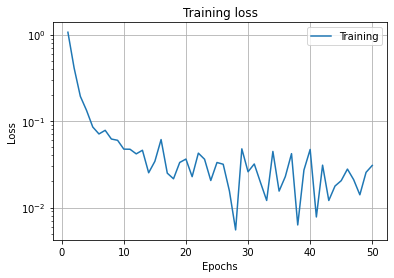

In [123]:
neural_network.plot_metric(h, 'loss')

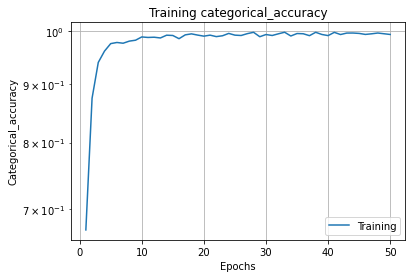

In [124]:
neural_network.plot_metric(h, 'categorical_accuracy')